
Scenario 1: Current Setup (1 Teller, 1 ATM)
Customer 1 arrives at 2.12 min
Customer 2 arrives at 3.87 min
Customer 2 finished ATM at 5.29 min (service=1.41)
Customer 3 arrives at 5.81 min
Customer 4 arrives at 8.09 min
Customer 3 finished ATM at 8.93 min (service=3.13)
Customer 1 finished Teller at 10.03 min (service=7.90)
Customer 5 arrives at 10.35 min
Customer 4 finished ATM at 10.59 min (service=1.66)
Customer 6 arrives at 12.81 min
Customer 7 arrives at 15.46 min
Customer 5 finished Teller at 15.72 min (service=5.38)
Customer 8 arrives at 18.20 min
Customer 8 finished ATM at 19.60 min (service=1.40)
Customer 9 arrives at 20.38 min
Customer 6 finished Teller at 21.75 min (service=6.03)
Customer 10 arrives at 21.91 min
Customer 10 finished ATM at 23.72 min (service=1.81)
Customer 11 arrives at 23.77 min
Customer 12 arrives at 24.77 min
Customer 7 finished Teller at 24.93 min (service=3.18)
Customer 11 finished ATM at 25.64 min (service=1.87)
Customer 13 arrives at 26.92 min
Custome

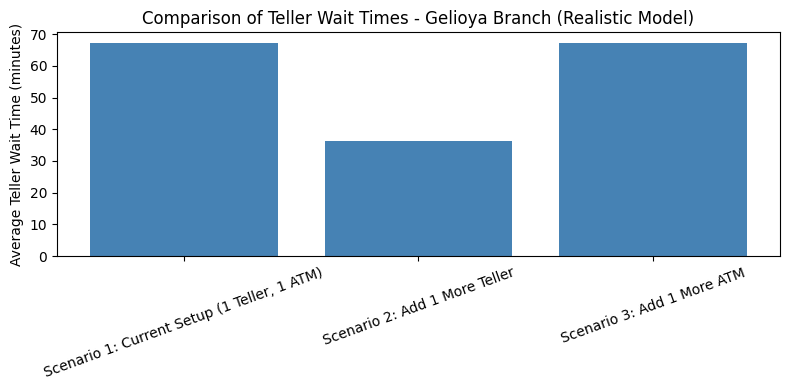

In [2]:
import simpy
import random
import statistics
import matplotlib.pyplot as plt

# -----------------------------
# Simulation Parameters (Sri Lankan Bank realistic)
# -----------------------------
RANDOM_SEED = 42
SIM_TIME = 360          # 6 hours (in minutes)
INTER_ARRIVAL = 5.0     # mean time between arrivals (minutes)

# Service times (in minutes)
TELLER_SERVICE_TIME = 7    # average teller service time

# -----------------------------
# Data Collection
# -----------------------------
wait_times_teller = []
wait_times_atm = []
queue_lengths_teller = []
queue_lengths_atm = []

# -----------------------------
# Customer Process
# -----------------------------
def customer(env, name, teller, atm):
    """Process for each customer: decides teller or ATM and records times."""
    arrival_time = env.now
    print(f"{name} arrives at {arrival_time:.2f} min")

    # 30% of customers use the ATM
    if random.random() < 0.3:
        with atm.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times_atm.append(wait)

            # --- More realistic ATM timing ---
            operating_time = random.uniform(1.0, 1.2)   # insert card, select menu, etc.
            transaction_time = random.uniform(0.3, 0.8) # actual withdrawal
            total_service_time = operating_time + transaction_time

            # occasional slow customer (5%)
            if random.random() < 0.05:
                total_service_time += random.uniform(0.5, 1.5)

            yield env.timeout(total_service_time)
            print(f"{name} finished ATM at {env.now:.2f} min (service={total_service_time:.2f})")

    else:
        with teller.request() as request:
            yield request
            wait = env.now - arrival_time
            wait_times_teller.append(wait)

            # Teller service (exponentially distributed)
            service_time = random.expovariate(1.0 / TELLER_SERVICE_TIME)
            yield env.timeout(service_time)
            print(f"{name} finished Teller at {env.now:.2f} min (service={service_time:.2f})")

# -----------------------------
# Customer Arrival Generator
# -----------------------------
def customer_arrivals(env, teller, atm):
    """Generates customers with realistic arrival gaps."""
    i = 0
    while True:
        # Normal (Gaussian) distributed arrivals → more natural spacing
        arrival_gap = max(random.normalvariate(INTER_ARRIVAL, 0.5), 1.0)
        yield env.timeout(arrival_gap)
        i += 1
        env.process(customer(env, f"Customer {i}", teller, atm))
        queue_lengths_teller.append(len(teller.queue))
        queue_lengths_atm.append(len(atm.queue))

# -----------------------------
# Run Simulation
# -----------------------------
def run_simulation(num_tellers=1, num_atms=1, arrival_rate=INTER_ARRIVAL):
    global INTER_ARRIVAL
    INTER_ARRIVAL = arrival_rate

    wait_times_teller.clear()
    wait_times_atm.clear()
    queue_lengths_teller.clear()
    queue_lengths_atm.clear()

    random.seed(RANDOM_SEED)
    env = simpy.Environment()

    teller = simpy.Resource(env, capacity=num_tellers)
    atm = simpy.Resource(env, capacity=num_atms)

    env.process(customer_arrivals(env, teller, atm))
    env.run(until=SIM_TIME)

    # Calculate statistics
    avg_wait_teller = statistics.mean(wait_times_teller) if wait_times_teller else 0
    avg_wait_atm = statistics.mean(wait_times_atm) if wait_times_atm else 0

    print("\n----- Simulation Results -----")
    print(f"Avg Teller Wait Time: {avg_wait_teller:.2f} mins")
    print(f"Avg ATM Wait Time: {avg_wait_atm:.2f} mins")
    print(f"Max Teller Queue: {max(queue_lengths_teller, default=0)}")
    print(f"Max ATM Queue: {max(queue_lengths_atm, default=0)}")

    return avg_wait_teller, avg_wait_atm

# -----------------------------
# Scenarios
# -----------------------------
scenarios = {
    "Scenario 1: Current Setup (1 Teller, 1 ATM)": (1, 1, 2.0),
    "Scenario 2: Add 1 More Teller": (2, 1, 2.0),
    "Scenario 3: Add 1 More ATM": (1, 2, 2.0)
}

results = {}

for name, (tellers, atms, arrival) in scenarios.items():
    print("\n===============================")
    print(name)
    print("===============================")
    avg_teller, avg_atm = run_simulation(num_tellers=tellers, num_atms=atms, arrival_rate=arrival)
    results[name] = (avg_teller, avg_atm)

# -----------------------------
# Plot Results
# -----------------------------
plt.figure(figsize=(8, 4))
plt.bar(results.keys(), [v[0] for v in results.values()], color='steelblue')
plt.ylabel('Average Teller Wait Time (minutes)')
plt.title('Comparison of Teller Wait Times - Gelioya Branch (Realistic Model)')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


In [ ]:
print("\nSimulation complete.")